In [1]:
import functools
from typing import Literal, Optional, Iterable

import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
import optax
import scanpy as sc
from ott.neural import datasets
from ott.neural.methods.flows import dynamics, otfm
from ott.neural.networks.layers import time_encoder
from ott.neural.networks.velocity_field import VelocityField
from ott.solvers import utils as solver_utils
from torch.utils.data import DataLoader
from tqdm import tqdm
import joypy
import pandas as pd
import pickle

In [2]:
def reconstruct_data(embedding: np.ndarray, projection_matrix: np.ndarray, mean_to_add: np.ndarray) -> np.ndarray:
    return np.matmul(embedding, projection_matrix.T) + mean_to_add

In [3]:
obsm_key_cond = "ecfp_cell_line_logdose_more_dose"
obsm_key_data = "X_pca"

In [4]:
adata_train_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_train_biolord_split_30.h5ad"
adata_test_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_test_biolord_split_30.h5ad"
adata_ood_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_ood_biolord_split_30.h5ad"

In [5]:
adata_train = sc.read(adata_train_path)
adata_ood = sc.read(adata_ood_path)
adata_test = sc.read(adata_test_path)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
adata_train.obsm["ecfp_cell_line_logdose_more_dose"].shape

(309540, 1424)

In [7]:
source_dim=30
target_dim=30
condition_dim=1424

In [8]:
vf = VelocityField(
    hidden_dims= [1024, 1024, 1024],
    output_dims= [1024, 1024, 1024] + [target_dim],
    condition_dims= [4096, 4096, 4096],
    time_dims= [512, 512, 512],
    time_encoder=functools.partial(time_encoder.cyclical_time_encoder, n_freqs=1024),
)

model = otfm.OTFlowMatching(
    vf,
    flow=dynamics.ConstantNoiseFlow(0),
    match_fn=None,
    condition_dim=condition_dim,
    rng=jax.random.PRNGKey(13),
    optimizer=optax.MultiSteps(optax.adam(learning_rate=1e-4), 20),
)


2024-05-27 15:28:16.002370: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [9]:
load_path = f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/sciplex_biolord_split/pious-microwave-2072_model.pkl"

# Open the file containing the saved parameters
with open(load_path, 'rb') as f:
    loaded_params = pickle.load(f)

In [10]:
from flax.core.frozen_dict import FrozenDict
new_params = FrozenDict(loaded_params)

if hasattr(model.vf_state, 'replace'):
    model.vf_state = model.vf_state.replace(params=new_params)
else:
    raise ValueError

In [11]:
OBSM_KEY_DATA = "X_pca"
OBSM_KEY_COND = "ecfp_cell_line_logdose_more_dose"

In [12]:
def load_data(adata, obsm_key_data, obsm_key_cond):
    """Loads data and preprocesses it based on configuration."""
    dls = []
    data_source = {}
    data_target = {}
    data_source_decoded = {}
    data_target_decoded = {}
    data_conditions = {}
    for cond in adata.obs["condition"].cat.categories:
        if "Vehicle" not in cond:
            src_str_unique = list(adata[adata.obs["condition"] == cond].obs["cell_type"].unique())
            assert len(src_str_unique) == 1
            src_str = src_str_unique[0] + "_Vehicle_0.0"
            source = adata[adata.obs["condition"] == src_str].obsm[obsm_key_data]
            source_decoded = adata[adata.obs["condition"] == src_str].X.A
            target = adata[adata.obs["condition"] == cond].obsm[obsm_key_data]
            target_decoded = adata[adata.obs["condition"] == cond].X.A
            conds = adata[adata.obs["condition"] == cond].obsm[obsm_key_cond]
            assert np.all(np.all(conds == conds[0], axis=1))
            conds = np.tile(conds[0], (len(source), 1))
            data_source[cond] = source
            data_target[cond] = target
            data_source_decoded[cond] = source_decoded
            data_target_decoded[cond] = target_decoded
            data_conditions[cond] = conds
    return {
        "source": data_source,
        "target": data_target,
        "source_decoded": data_source_decoded,
        "target_decoded": data_target_decoded,
        "conditions": data_conditions,
    }


In [13]:
test_data_dict = load_data(adata_test, OBSM_KEY_DATA, OBSM_KEY_COND)

In [14]:
reconstruct_data_fn = functools.partial(
        reconstruct_data, projection_matrix=adata_train.varm["PCs"], mean_to_add=adata_train.varm["X_train_mean"].T
    )

In [39]:
def interpolate_continuous_covariate(model, source: jnp.ndarray, condition_without_covariate: jnp.ndarray, covariate_values: Iterable):
    assert condition_without_covariate.shape[0] == 1 # we only do one condition
    conditions = {}
    for cov in covariate_values:
        conds = np.concatenate((condition_without_covariate, jnp.array([[cov] * 100])), axis=-1)
        conditions[cov] = np.tile(conds, (len(source), 1))
    return jtu.tree_map(lambda c: functools.partial(model.transport, x=source)(condition=c), conditions)

In [40]:
[el for el in test_data_dict["conditions"].keys() if "Pracinostat" in el]



['K562_Pracinostat_(SB939)_10.0',
 'MCF7_Pracinostat_(SB939)_10.0',
 'MCF7_Pracinostat_(SB939)_100.0',
 'MCF7_Pracinostat_(SB939)_1000.0',
 'MCF7_Pracinostat_(SB939)_10000.0']

In [17]:
adata = adata_test

In [42]:
perturbation_condition = "MCF7_Pracinostat_(SB939)_10000.0"
src_str_unique = list(adata[adata.obs["condition"] == perturbation_condition].obs["cell_type"].unique())
assert len(src_str_unique) == 1
src_str = src_str_unique[0] + "_Vehicle_0.0"
source = adata[adata.obs["condition"] == src_str].obsm[OBSM_KEY_DATA]
conds = adata[adata.obs["condition"] == perturbation_condition].obsm[OBSM_KEY_COND]
condition_without_covariate = conds[0,...,:-100][None,...]
covariate_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]



In [43]:
interpolation_results = interpolate_continuous_covariate(model, source, condition_without_covariate, covariate_values)


In [44]:
prediction_decoded = jtu.tree_map(reconstruct_data_fn, interpolation_results)

In [45]:
dfs = []
for k, preds in prediction_decoded.items():
    df = pd.DataFrame(data=preds, columns=adata_train.var_names)
    df["dosage"] = k
    df["mode"] = "predicted"
    dfs.append(df)

In [46]:
df_preds = pd.concat(dfs)

In [47]:
gene1 = "ACSS2"

In [48]:
adata = adata_test

In [49]:
pert_condition_without_dose = "MCF7_Pracinostat_(SB939)_"
dfs_ground_truth = []
for dose in adata.obs["dose"].unique():
    if dose == 0.0:
        continue
    pert_condition = pert_condition_without_dose + str(dose)
    cols = pd.Index([gene+"_true" for gene in adata_train.var_names])
    df = pd.DataFrame(data=adata_train[adata_train.obs["condition"]==pert_condition].X.A, columns=cols)
    df["dosage"] = np.log10(dose)
    df["mode"] = "true"
    dfs_ground_truth.append(df)
    

In [50]:
df_preds.index = df_preds.index.map(lambda x: f"{x}-2")

In [51]:
df_preds.index = np.arange(len(df_preds))

In [56]:
df_ground_truth = pd.concat(dfs_ground_truth)

In [57]:
df_ground_truth.index = np.arange(len(df_ground_truth)) + 10000

In [ ]:
df = pd.concat((df_ground_truth, df_preds), axis=1)

In [ ]:
df = df_ground_truth

In [ ]:
df_preds.dosage.unique()

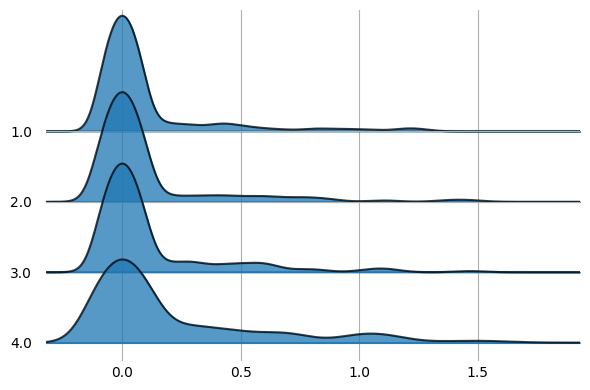

In [59]:
fig, axes = joyplot(
    df_ground_truth[[gene1+"_true", "dosage"]],
    by='dosage',
    alpha=0.75,
    figsize=(6, 4),
    grid='both',
    kind="kde",
)

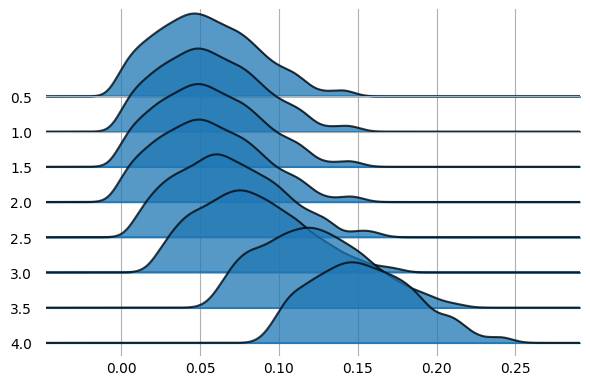

In [53]:
fig, axes = joyplot(
    df_preds[[gene1, "dosage"]],
    by='dosage',
    alpha=0.75,
    figsize=(6, 4),
    grid='both',
    kind="kde",
)

In [61]:
df_preds[[gene1, "dosage"]]

index     ACSS2  dosage
0      0.058986     0.5
1      0.027842     0.5
2      0.032201     0.5
3      0.054970     0.5
4      0.033592     0.5
...         ...     ...
3995   0.191557     4.0
3996   0.174336     4.0
3997   0.193857     4.0
3998   0.160961     4.0
3999   0.116817     4.0

[4000 rows x 2 columns]

In [63]:
df_ground_truth[[gene1+"_true", "dosage"]]

ACSS2_true  dosage
10000         0.0     1.0
10001         0.0     1.0
10002         0.0     1.0
10003         0.0     1.0
10004         0.0     1.0
...           ...     ...
11277         0.0     3.0
11278         0.0     3.0
11279         0.0     3.0
11280         0.0     3.0
11281         0.0     3.0

[1282 rows x 2 columns]

In [64]:
df_ground_truth[gene1+"_true"].value_counts()

ACSS2_true
0.000000    1098
1.466185       2
1.096636       1
0.229909       1
0.288626       1
            ... 
1.080335       1
1.030308       1
1.164951       1
1.092706       1
0.287040       1
Name: count, Length: 184, dtype: int64

In [38]:
prediction_decoded.keys()

dict_keys([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])

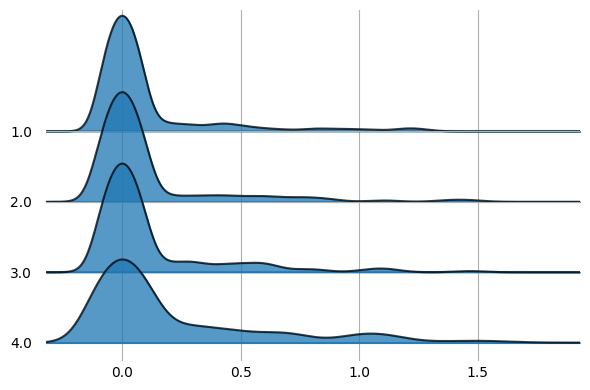

In [48]:
fig, axes = joyplot(
    df[[gene1+"_true", "dosage"]],
    by='dosage',
    alpha=0.75,
    figsize=(6, 4),
    grid='both',
    kind="kde",
)

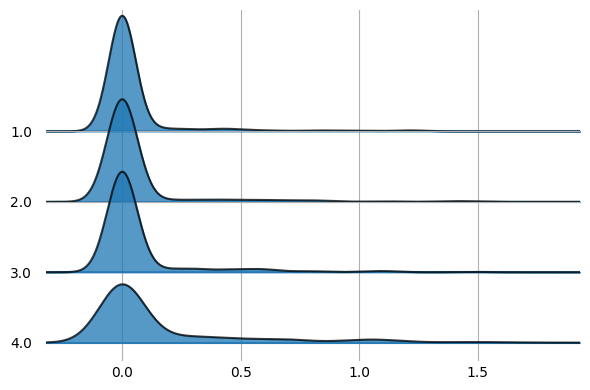

In [49]:
fig, axes = joypy.joyplot(
    df[[gene1+"_true", "dosage"]],
    by='dosage',
    alpha=0.75,
    figsize=(6, 4),
    grid='both',
    kind="kde",
)

In [65]:
prediction_decoded.keys()

dict_keys([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])

In [68]:
prediction_decoded[0.5].shape

(500, 2002)

In [88]:
counts_pred = np.concatenate(list(prediction_decoded.values()))

In [91]:
import anndata
obs_arr=[]
for dose in prediction_decoded.keys():
    obs_arr.append([dose] * 500)

In [93]:
adata_pred = anndata.AnnData(counts_pred)

In [95]:
adata_pred.obs["dose"] = np.concatenate(obs_arr)

In [96]:
sc.pp.neighbors(adata_pred)
sc.tl.umap(adata_pred)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [98]:
adata_pred.obs["dose_cat"] = adata_pred.obs["dose"].astype("category")

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


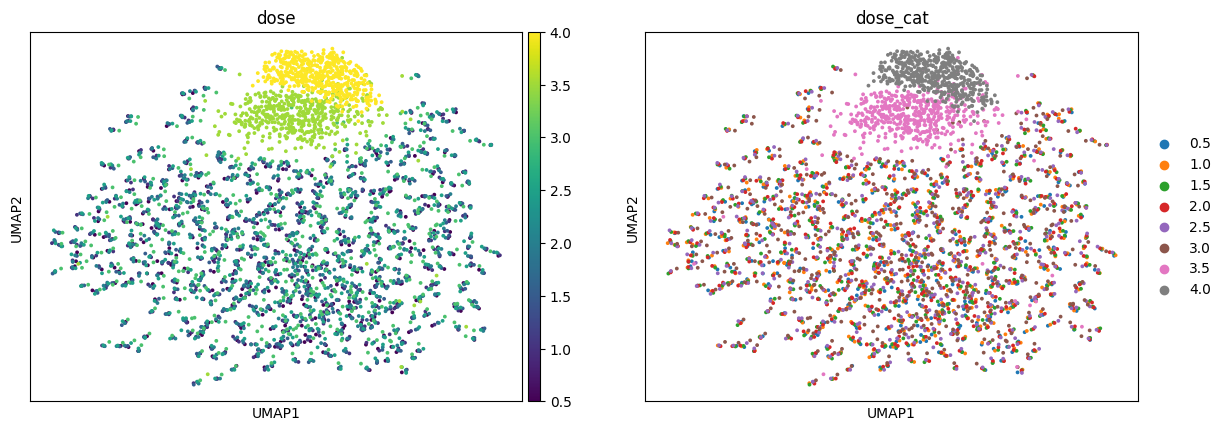

In [99]:
sc.pl.umap(adata_pred, color=["dose", "dose_cat"])

In [104]:
adata_true = adata["MCF7_Pracinostat_(SB939)" in adata.obs["condition"]]

In [102]:
adata_tmp = adata[adata.]

cell_type  dose dose_character dose_pattern  \
index                                                                          
A01_E09_RT_BC_100_Lig_BC_306-0-0      A549  10.0             10            4   

                                 g1s_score g2m_score     pathway  \
index                                                              
A01_E09_RT_BC_100_Lig_BC_306-0-0       0.0  1.980748  DNA Damage   

                                          pathway_level_1    pathway_level_2  \
index                                                                          
A01_E09_RT_BC_100_Lig_BC_306-0-0  DNA damage & DNA repair  Nucleotide analog   

                                    product_dose  ... cell_line logdose  \
index                                             ...                     
A01_E09_RT_BC_100_Lig_BC_306-0-0  Raltitrexed_10  ...      A549     1.0   

                                              condition pubchem_name  \
index                                                                  
A01_E09_RT_BC_100_Lig_BC_306-0-0  A549_Raltitrexed_10.0  Raltitrexed   

                                 pubchem_ID  \
index                                         
A01_E09_RT_BC_100_Lig_BC_306-0-0  135400182   

                                                                             smiles  \
index                                                                                 
A01_E09_RT_BC_100_Lig_BC_306-0-0  CC1=NC2=C(C=C(C=C2)CN(C)C3=CC=C(S3)C(=O)NC(CCC...   

                                 control      ood is_ood split  
index                                                           
A01_E09_RT_BC_100_Lig_BC_306-0-0       0  not ood  False  test  

[1 rows x 28 columns]

In [105]:
adata_true

View of AnnData object with n_obs × n_vars = 1 × 2002
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle', 'perturbation', 'drug', 'cell_line', 'logdose', 'condition', 'pubchem_name', 'pubchem_ID', 'smiles', 'control', 'ood', 'is_ood', 'split'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups_cov_all'
    obsm: 'X_pca', 'cell_line_emb', 'ecfp', 'ecfp_cell_line', 'ecfp_cell_line_dose', 'ecfp_cell_line_dose_more_dose', 'ecfp_cell_line_logdose', 'ecfp_cell_line_logdose_more_dose'
    varm: 'X_train_mean'
    layers: 'centered_X'

In [109]:
adata_tmp = adata[(adata.obs["drug"]=="Pracinostat_(SB939)") & (adata.obs["cell_type"]=="MCF7")]

array([0.7786693, 0.7786693, 0.7786693, 1.2110902, 0.7786693, 0.7786693,
       1.2110902, 0.7786693, 1.5119826, 0.7786693, 2.0883305, 1.2110902,
       0.7786693, 0.7786693, 0.7786693, 0.7786693, 2.5483284, 0.7786693,
       1.2110902, 0.7786693, 1.7429693, 1.2110902, 1.7429693, 0.7786693,
       0.7786693, 1.5119826, 0.7786693, 0.7786693, 0.7786693, 0.7786693,
       0.7786693, 0.7786693, 0.7786693], dtype=float32)

In [108]:
adata_tmp.obs

cell_type     dose dose_character  \
index                                                                
A01_E09_RT_BC_160_Lig_BC_213-1-0      MCF7    100.0            100   
A01_E09_RT_BC_244_Lig_BC_148-1-0      MCF7   1000.0           1000   
A01_E09_RT_BC_295_Lig_BC_11-1-0       MCF7   1000.0           1000   
A01_E09_RT_BC_343_Lig_BC_369-1-0      MCF7    100.0            100   
A01_E09_RT_BC_61_Lig_BC_364-1-0       MCF7  10000.0          10000   
...                                    ...      ...            ...   
H09_E09_RT_BC_292_Lig_BC_316-1        K562     10.0             10   
H09_F10_RT_BC_249_Lig_BC_220-1        K562     10.0             10   
H10_E09_RT_BC_30_Lig_BC_199-1         K562     10.0             10   
H10_F10_RT_BC_352_Lig_BC_160-1        K562     10.0             10   
H11_F10_RT_BC_333_Lig_BC_162-1        K562     10.0             10   

                                 dose_pattern g1s_score g2m_score  \
index                                                               
A01_E09_RT_BC_160_Lig_BC_213-1-0            3  0.000000  0.000000   
A01_E09_RT_BC_244_Lig_BC_148-1-0            2  0.910365  1.378882   
A01_E09_RT_BC_295_Lig_BC_11-1-0             2  1.575331  1.070272   
A01_E09_RT_BC_343_Lig_BC_369-1-0            3  0.862026  0.862026   
A01_E09_RT_BC_61_Lig_BC_364-1-0             1  1.737651  2.082682   
...                                       ...       ...       ...   
H09_E09_RT_BC_292_Lig_BC_316-1              4  2.041466  1.698899   
H09_F10_RT_BC_249_Lig_BC_220-1              4  1.729025  0.000000   
H10_E09_RT_BC_30_Lig_BC_199-1               4  1.953310  2.147683   
H10_F10_RT_BC_352_Lig_BC_160-1              4  2.083458  1.207187   
H11_F10_RT_BC_333_Lig_BC_162-1              4  1.151158  1.445218   

                                                 pathway  \
index                                                      
A01_E09_RT_BC_160_Lig_BC_213-1-0  Cytoskeletal Signaling   
A01_E09_RT_BC_244_Lig_BC_148-1-0  Cytoskeletal Signaling   
A01_E09_RT_BC_295_Lig_BC_11-1-0   Cytoskeletal Signaling   
A01_E09_RT_BC_343_Lig_BC_369-1-0  Cytoskeletal Signaling   
A01_E09_RT_BC_61_Lig_BC_364-1-0   Cytoskeletal Signaling   
...                                                  ...   
H09_E09_RT_BC_292_Lig_BC_316-1    Cytoskeletal Signaling   
H09_F10_RT_BC_249_Lig_BC_220-1    Cytoskeletal Signaling   
H10_E09_RT_BC_30_Lig_BC_199-1     Cytoskeletal Signaling   
H10_F10_RT_BC_352_Lig_BC_160-1    Cytoskeletal Signaling   
H11_F10_RT_BC_333_Lig_BC_162-1    Cytoskeletal Signaling   

                                        pathway_level_1  \
index                                                     
A01_E09_RT_BC_160_Lig_BC_213-1-0  Epigenetic regulation   
A01_E09_RT_BC_244_Lig_BC_148-1-0  Epigenetic regulation   
A01_E09_RT_BC_295_Lig_BC_11-1-0   Epigenetic regulation   
A01_E09_RT_BC_343_Lig_BC_369-1-0  Epigenetic regulation   
A01_E09_RT_BC_61_Lig_BC_364-1-0   Epigenetic regulation   
...                                                 ...   
H09_E09_RT_BC_292_Lig_BC_316-1    Epigenetic regulation   
H09_F10_RT_BC_249_Lig_BC_220-1    Epigenetic regulation   
H10_E09_RT_BC_30_Lig_BC_199-1     Epigenetic regulation   
H10_F10_RT_BC_352_Lig_BC_160-1    Epigenetic regulation   
H11_F10_RT_BC_333_Lig_BC_162-1    Epigenetic regulation   

                                        pathway_level_2  \
index                                                     
A01_E09_RT_BC_160_Lig_BC_213-1-0  Histone deacetylation   
A01_E09_RT_BC_244_Lig_BC_148-1-0  Histone deacetylation   
A01_E09_RT_BC_295_Lig_BC_11-1-0   Histone deacetylation   
A01_E09_RT_BC_343_Lig_BC_369-1-0  Histone deacetylation   
A01_E09_RT_BC_61_Lig_BC_364-1-0   Histone deacetylation   
...                                                 ...   
H09_E09_RT_BC_292_Lig_BC_316-1    Histone deacetylation   
H09_F10_RT_BC_249_Lig_BC_220-1    Histone deacetylation   
H10_E09_RT_BC_30_Lig_BC_199-1     Histone deacetylation   
H10_F10_RT_BC_352_Lig_BC_1

In [30]:
import numpy as np
from scipy.stats import gaussian_kde
import scipy.stats as stats

import warnings

try:
    # pandas < 0.25
    from pandas.plotting._tools import (_subplots, _flatten)
except ImportError:
    try:
        #pandas >= 0.25, <1.2.0
        from pandas.plotting._matplotlib.tools import (_subplots, _flatten)
    except ImportError:
        #pandas >= 1.2.0
        from pandas.plotting._matplotlib.tools import create_subplots as _subplots
        from pandas.plotting._matplotlib.tools import flatten_axes as _flatten

from pandas import (DataFrame, Series)
from pandas.core.dtypes.common import is_number
from pandas.core.groupby import DataFrameGroupBy
from matplotlib import pyplot as plt
from warnings import warn

_DEBUG = False

def _x_range(data, extra=0.2):
    """ Compute the x_range, i.e., the values for which the
        density will be computed. It should be slightly larger than
        the max and min so that the plot actually reaches 0, and
        also has a bit of a tail on both sides.
    """
    try:
        sample_range = np.nanmax(data) - np.nanmin(data)
    except ValueError:
        return []
    if sample_range < 1e-6:
        return [np.nanmin(data), np.nanmax(data)]
    return np.linspace(np.nanmin(data) - extra*sample_range,
                       np.nanmax(data) + extra*sample_range, 1000)

def _setup_axis(ax, x_range, col_name=None, grid=False, ylabelsize=None, yrot=None):
    """ Setup the axis for the joyplot:
        - add the y label if required (as an ytick)
        - add y grid if required
        - make the background transparent
        - set the xlim according to the x_range
        - hide the xaxis and the spines
    """
    if col_name is not None:
        ax.set_yticks([0])
        ax.set_yticklabels([col_name], fontsize=ylabelsize, rotation=yrot)
        ax.yaxis.grid(grid)
    else:
        ax.yaxis.set_visible(False)
    ax.patch.set_alpha(0)
    ax.set_xlim([min(x_range), max(x_range)])
    ax.tick_params(axis='both', which='both', length=0, pad=10)
    ax.xaxis.set_visible(_DEBUG)
    ax.set_frame_on(_DEBUG)

def _is_numeric(x):
    """ Whether the array x is numeric. """
    return all(is_number(i) for i in x)

def _get_alpha(i, n, start=0.4, end=1.0):
    """ Compute alpha value at position i out of n """
    return start + (1 + i)*(end - start)/n

def _remove_na(l):
    """ Remove NA values. Should work for lists, arrays, series. """
    return Series(l).dropna().values

def _moving_average(a, n=3, zero_padded=False):
    """ Moving average of order n.
        If zero padded, returns an array of the same size as
        the input: the values before a[0] are considered to be 0.
        Otherwise, returns an array of length len(a) - n + 1 """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    if zero_padded:
        return ret / n
    else:
        return ret[n - 1:] / n

def joyplot(data, column=None, by=None, grid=False,
            xlabelsize=None, xrot=None, ylabelsize=None, yrot=None,
            ax=None, figsize=None,
            hist=False, bins=10,
            fade=False, ylim='max',
            fill=True, linecolor=None,
            overlap=1, background=None,
            labels=None, xlabels=True, ylabels=True,
            range_style='all',
            x_range=None,
            title=None,
            colormap=None,
            color=None,
            normalize=True,
            floc=None,
            **kwds):
    """
    Draw joyplot of a DataFrame, or appropriately nested collection,
    using matplotlib and pandas.

    A joyplot is a stack of vertically aligned density plots / histograms.
    By default, if 'data' is a DataFrame,
    this function will plot a density plot for each column.

    This wrapper method tries to convert whatever structure is given
    to a nested collection of lists with additional information
    on labels, and use the private _joyplot function to actually
    draw theh plot.

    Parameters
    ----------
    data : DataFrame, Series or nested collection
    column : string or sequence
        If passed, will be used to limit data to a subset of columns
    by : object, optional
        If passed, used to form separate plot groups
    grid : boolean, default True
        Whether to show axis grid lines
    labels : boolean or list, default True.
        If list, must be the same size of the de
    xlabelsize : int, default None
        If specified changes the x-axis label size
    xrot : float, default None
        rotation of x axis labels
    ylabelsize : int, default None
        If specified changes the y-axis label size
    yrot : float, default None
        rotation of y axis labels
    ax : matplotlib axes object, default None
    figsize : tuple
        The size of the figure to create in inches by default
    hist : boolean, default False
    bins : integer, default 10
        Number of histogram bins to be used
    color : color or colors to be used in the plots. It can be:
        a string or anything interpretable as color by matplotib;
        a list of colors. See docs / examples for more details.
    kwds : other plotting keyword arguments
        To be passed to hist/kde plot function
    """

    if column is not None:
        if not isinstance(column, (list, np.ndarray)):
            column = [column]

    def _grouped_df_to_standard(grouped, column):
        converted = []
        labels = []
        for i, (key, group) in enumerate(grouped):
            if column is not None:
                group = group[column]
            labels.append(key)
            converted.append([_remove_na(group[c]) for c in group.columns if _is_numeric(group[c])])
            if i == 0:
                sublabels = [col for col in group.columns if _is_numeric(group[col])]
        return converted, labels, sublabels

    #################################################################
    # GROUPED
    # - given a grouped DataFrame, a group by key, or a dict of dicts of Series/lists/arrays
    # - select the required columns/Series/lists/arrays
    # - convert to standard format: list of lists of non-null arrays
    #   + extra parameters (labels and sublabels)
    #################################################################
    if isinstance(data, DataFrameGroupBy):
        grouped = data
        converted, _labels, sublabels = _grouped_df_to_standard(grouped, column)
        if labels is None:
            labels = _labels
    elif by is not None and isinstance(data, DataFrame):
        grouped = data.groupby(by)
        if column is None:
            # Remove the groupby key. It's not automatically removed by pandas.
            column = list(data.columns)
            column.remove(by)
        converted, _labels, sublabels = _grouped_df_to_standard(grouped, column)
        if labels is None:
            labels = _labels
        # If there is at least an element which is not a list of lists.. go on.
    elif isinstance(data, dict) and all(isinstance(g, dict) for g in data.values()):
        grouped = data
        if labels is None:
            labels = list(grouped.keys())
        converted = []
        for i, (key, group) in enumerate(grouped.items()):
            if column is not None:
                converted.append([_remove_na(g) for k,g in group.items() if _is_numeric(g) and k in column])
                if i == 0:
                    sublabels = [k for k,g in group.items() if _is_numeric(g)]
            else:
                converted.append([_remove_na(g) for k,g in group.items() if _is_numeric(g)])
                if i == 0:
                    sublabels = [k for k,g in group.items() if _is_numeric(g)]
    #################################################################
    # PLAIN:
    # - given a DataFrame or list/dict of Series/lists/arrays
    # - select the required columns/Series/lists/arrays
    # - convert to standard format: list of lists of non-null arrays + extra parameter (labels)
    #################################################################
    elif isinstance(data, DataFrame):
        if column is not None:
            data = data[column]
        converted = [[_remove_na(data[col])] for col in data.columns if _is_numeric(data[col])]
        labels = [col for col in data.columns if _is_numeric(data[col])]
        sublabels = None
    elif isinstance(data, dict):
        if column is not None:
            converted = [[_remove_na(g)] for k,g in data.items() if _is_numeric(g) and k in column]
            labels = [k for k,g in data.items() if _is_numeric(g) and k in column]
        else:
            converted = [[_remove_na(g)] for k,g in data.items() if _is_numeric(g)]
            labels = [k for k,g in data.items() if _is_numeric(g)]
        sublabels = None
    elif isinstance(data, list):
        if column is not None:
            converted = [[_remove_na(g)] for g in data if _is_numeric(g) and i in column]
        else:
            converted = [[_remove_na(g)] for g in data if _is_numeric(g)]
        if labels and len(labels) != len(converted):
            raise ValueError("The number of labels does not match the length of the list.")

        sublabels = None
    else:
        raise TypeError("Unknown type for 'data': {!r}".format(type(data)))

    if ylabels is False:
        labels = None

    if all(len(subg)==0 for g in converted for subg in g):
        raise ValueError("No numeric values found. Joyplot requires at least a numeric column/group.")

    if any(len(subg)==0 for g in converted for subg in g):
        warn("At least a column/group has no numeric values.")


    return _joyplot(converted, labels=labels, sublabels=sublabels,
                    grid=grid,
                    xlabelsize=xlabelsize, xrot=xrot, ylabelsize=ylabelsize, yrot=yrot,
                    ax=ax, figsize=figsize,
                    hist=hist, bins=bins,
                    fade=fade, ylim=ylim,
                    fill=fill, linecolor=linecolor,
                    overlap=overlap, background=background,
                    xlabels=xlabels,
                    range_style=range_style, x_range=x_range,
                    title=title,
                    colormap=colormap,
                    color=color,
                    normalize=normalize,
                    floc=floc,
                    **kwds)

###########################################

def plot_density(ax, x_range, v, kind="kde", bw_method=None,
                 bins=50,
                 fill=False, linecolor=None, clip_on=True,
                 normalize=True, floc=None,**kwargs):
    """ Draw a density plot given an axis, an array of values v and an array
        of x positions where to return the estimated density.
    """
    v = _remove_na(v)
    if len(v) == 0 or len(x_range) == 0:
        return

    if kind == "kde":
        try:
            gkde = gaussian_kde(v, bw_method=bw_method)
            y = gkde.evaluate(x_range)
            y = np.log(y+1.0)
        except ValueError:
            # Handle cases where there is no data in a group.
            y = np.zeros_like(x_range)
        except np.linalg.LinAlgError as e:
            # Handle singular matrix in kde computation.
            distinct_values = np.unique(v)
            if len(distinct_values) == 1:
                # In case of a group with a single value val,
                # that should have infinite density,
                # return a δ(val)
                val = distinct_values[0]
                warnings.warn("The data contains a group with a single distinct value ({}) "
                              "having infinite probability density. "
                              "Consider using a different visualization.".format(val))

                # Find index i of x_range
                # such that x_range[i-1] < val ≤ x_range[i]
                i = np.searchsorted(x_range, val)

                y = np.zeros_like(x_range)
                y[i] = 1
            else:
                raise e

    elif kind == "lognorm":
        if floc is not None:
            lnparam = stats.lognorm.fit(v,loc=floc)
        else:
            lnparam = stats.lognorm.fit(v)

        lpdf = stats.lognorm.pdf(x_range,lnparam[0],lnparam[1],lnparam[2])
        if normalize:
            y = lpdf/lpdf.sum()
        else:
            y = lpdf
    elif kind == "counts":
        y, bin_edges = np.histogram(v, bins=bins, range=(min(x_range), max(x_range)))
        # np.histogram returns the edges of the bins.
        # We compute here the middle of the bins.
        x_range = _moving_average(bin_edges, 2)
    elif kind == "normalized_counts":
        y, bin_edges = np.histogram(v, bins=bins, density=False,
                                    range=(min(x_range), max(x_range)))
        # np.histogram returns the edges of the bins.
        # We compute here the middle of the bins.
        y = y / len(v)
        x_range = _moving_average(bin_edges, 2)
    elif kind == "values":
        # Warning: to use values and get a meaningful visualization,
        # x_range must also be manually set in the main function.
        y = v
        x_range = list(range(len(y)))
    else:
        raise NotImplementedError

    if fill:

        ax.fill_between(x_range, 0.0, y, clip_on=clip_on, **kwargs)

        # Hack to have a border at the bottom at the fill patch
        # (of the same color of the fill patch)
        # so that the fill reaches the same bottom margin as the edge lines
        # with y value = 0.0
        kw = kwargs
        kw["label"] = None
        ax.plot(x_range, [0.0]*len(x_range), clip_on=clip_on, **kw)

    if linecolor is not None:
        kwargs["color"] = linecolor

    # Remove the legend labels if we are plotting filled curve:
    # we only want one entry per group in the legend (if shown).
    if fill:
        kwargs["label"] = None

    ax.plot(x_range, y, clip_on=clip_on, **kwargs)


###########################################

def _joyplot(data,
             grid=False,
             labels=None, sublabels=None,
             xlabels=True,
             xlabelsize=None, xrot=None,
             ylabelsize=None, yrot=None,
             ax=None, figsize=None,
             hist=False, bins=10,
             fade=False,
             xlim=None, ylim='max',
             fill=True, linecolor=None,
             overlap=1, background=None,
             range_style='all', x_range=None, tails=0.2,
             title=None,
             legend=False, loc="upper right",
             colormap=None, color=None,
             normalize=True,
             floc=None,
             **kwargs):
    """
    Internal method.
    Draw a joyplot from an appropriately nested collection of lists
    using matplotlib and pandas.

    Parameters
    ----------
    data : DataFrame, Series or nested collection
    grid : boolean, default True
        Whether to show axis grid lines
    labels : boolean or list, default True.
        If list, must be the same size of the de
    xlabelsize : int, default None
        If specified changes the x-axis label size
    xrot : float, default None
        rotation of x axis labels
    ylabelsize : int, default None
        If specified changes the y-axis label size
    yrot : float, default None
        rotation of y axis labels
    ax : matplotlib axes object, default None
    figsize : tuple
        The size of the figure to create in inches by default
    hist : boolean, default False
    bins : integer, default 10
        Number of histogram bins to be used
    kwarg : other plotting keyword arguments
        To be passed to hist/kde plot function
    """

    if fill is True and linecolor is None:
        linecolor = "k"

    if sublabels is None:
        legend = False

    def _get_color(i, num_axes, j, num_subgroups):
        if isinstance(color, list):
            return color[j] if num_subgroups > 1 else color[i]
        elif color is not None:
            return color
        elif isinstance(colormap, list):
            return colormap[j](i/num_axes)
        elif color is None and colormap is None:
            num_cycle_colors = len(plt.rcParams['axes.prop_cycle'].by_key()['color'])
            return plt.rcParams['axes.prop_cycle'].by_key()['color'][j % num_cycle_colors]
        else:
            return colormap(i/num_axes)

    ygrid = (grid is True or grid == 'y' or grid == 'both')
    xgrid = (grid is True or grid == 'x' or grid == 'both')

    num_axes = len(data)

    if x_range is None:
        global_x_range = _x_range([v for g in data for sg in g for v in sg])
    else:
        global_x_range = _x_range(x_range, 0.0)
    global_x_min, global_x_max = min(global_x_range), max(global_x_range)

    # Each plot will have its own axis
    fig, axes = _subplots(naxes=num_axes, ax=ax, squeeze=False,
                          sharex=True, sharey=False, figsize=figsize,
                          layout_type='vertical')
    _axes = _flatten(axes)

    # The legend must be drawn in the last axis if we want it at the bottom.
    if loc in (3, 4, 8) or 'lower' in str(loc):
        legend_axis = num_axes - 1
    else:
        legend_axis = 0

    # A couple of simple checks.
    if labels is not None:
        assert len(labels) == num_axes
    if sublabels is not None:
        assert all(len(g) == len(sublabels) for g in data)
    if isinstance(color, list):
        assert all(len(g) <= len(color) for g in data)
    if isinstance(colormap, list):
        assert all(len(g) == len(colormap) for g in data)

    for i, group in enumerate(data):

        a = _axes[i]
        group_zorder = i
        if fade:
            kwargs['alpha'] = _get_alpha(i, num_axes)

        num_subgroups = len(group)

        if hist:
            # matplotlib hist() already handles multiple subgroups in a histogram
            a.hist(group, label=sublabels, bins=bins, color=color,
                   range=[min(global_x_range), max(global_x_range)],
                   edgecolor=linecolor, zorder=group_zorder, **kwargs)
        else:
            for j, subgroup in enumerate(group):

                # Compute the x_range of the current plot
                if range_style == 'all':
                # All plots have the same range
                    x_range = global_x_range
                elif range_style == 'own':
                # Each plot has its own range
                    x_range = _x_range(subgroup, tails)
                elif range_style == 'group':
                # Each plot has a range that covers the whole group
                    x_range = _x_range(group, tails)
                elif isinstance(range_style, (list, np.ndarray)):
                # All plots have exactly the range passed as argument
                    x_range = _x_range(range_style, 0.0)
                else:
                    raise NotImplementedError("Unrecognized range style.")

                if sublabels is None:
                    sublabel = None
                else:
                    sublabel = sublabels[j]

                element_zorder = group_zorder + j/(num_subgroups+1)
                element_color = _get_color(i, num_axes, j, num_subgroups)

                plot_density(a, x_range, subgroup,
                             fill=fill, linecolor=linecolor, label=sublabel,
                             zorder=element_zorder, color=element_color,
                             bins=bins, **kwargs)

        # Setup the current axis: transparency, labels, spines.
        col_name = None if labels is None else labels[i]
        _setup_axis(a, global_x_range, col_name=col_name, grid=ygrid,
                ylabelsize=ylabelsize, yrot=yrot)

        # When needed, draw the legend
        if legend and i == legend_axis:
            a.legend(loc=loc)
            # Bypass alpha values, in case
            for p in a.get_legend().get_patches():
                p.set_facecolor(p.get_facecolor())
                p.set_alpha(1.0)
            for l in a.get_legend().get_lines():
                l.set_alpha(1.0)


    # Final adjustments

    # Set the y limit for the density plots.
    # Since the y range in the subplots can vary significantly,
    # different options are available.
    if ylim == 'max':
        # Set all yaxis limit to the same value (max range among all)
        max_ylim = max(a.get_ylim()[1] for a in _axes)
        min_ylim = min(a.get_ylim()[0] for a in _axes)
        for a in _axes:
            a.set_ylim([min_ylim - 0.1*(max_ylim-min_ylim), max_ylim])

    elif ylim == 'own':
        # Do nothing, each axis keeps its own ylim
        pass

    else:
        # Set all yaxis lim to the argument value ylim
        try:
            for a in _axes:
                a.set_ylim(ylim)
        except:
            print("Warning: the value of ylim must be either 'max', 'own', or a tuple of length 2. The value you provided has no effect.")

    # Compute a final axis, used to apply global settings
    last_axis = fig.add_subplot(1, 1, 1)

    # Background color
    if background is not None:
        last_axis.patch.set_facecolor(background)

    for side in ['top', 'bottom', 'left', 'right']:
        last_axis.spines[side].set_visible(_DEBUG)

    # This looks hacky, but all the axes share the x-axis,
    # so they have the same lims and ticks
    last_axis.set_xlim(_axes[0].get_xlim())
    if xlabels is True:
        last_axis.set_xticks(np.array(_axes[0].get_xticks()[1:-1]))
        for t in last_axis.get_xticklabels():
            t.set_visible(True)
            t.set_fontsize(xlabelsize)
            t.set_rotation(xrot)

        # If grid is enabled, do not allow xticks (they are ugly)
        if xgrid:
            last_axis.tick_params(axis='both', which='both',length=0)
    else:
        last_axis.xaxis.set_visible(False)

    last_axis.yaxis.set_visible(False)
    last_axis.grid(xgrid)


    # Last axis on the back
    last_axis.zorder = min(a.zorder for a in _axes) - 1
    _axes = list(_axes) + [last_axis]

    if title is not None:
        plt.title(title)


    # The magic overlap happens here.
    h_pad = 5 + (- 5*(1 + overlap))
    fig.tight_layout(h_pad=h_pad)

    return fig, _axes

In [346]:
df_red = df[df.dosage.isin([1.0, 2.0, 3.0, 4.0])]

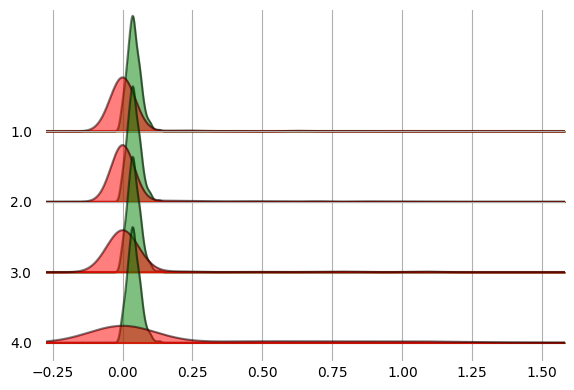

In [347]:
fig, axes = joypy.joyplot(
    df_red[[gene1, gene1+"_true", "dosage"]],
    by='dosage',
    color=["green", "red"],
    alpha=0.5,
    figsize=(6, 4),
    grid='both'
)

In [348]:
genes_to_plot = [el+"_true" for el in adata_train.var_names]

In [349]:
len(genes_to_plot)

2002

In [354]:
genes_to_check = df_ground_truth.drop(columns=["dosage", "mode"]).var(axis=0).argsort()[40:80].index

In [413]:
adata_train.var["means"].argmax()

237

In [417]:
adata_train.var.sort("means")

AttributeError: 'DataFrame' object has no attribute 'sort'

In [437]:
gg = ['SLC12A2']

In [460]:
gg = ["SCHLAP1"]

In [467]:
df

index       CFH      GCLC      TFPI    SLC4A1     CALCR    THSD7A     ACSM3  \
0      0.003651  0.053397  0.041352  0.001667  0.216778 -0.017640 -0.006087   
1      0.007765  0.090755  0.047978 -0.001972  0.483684  0.023830 -0.005568   
2      0.017151  0.072162  0.049568 -0.000415  0.147485  0.023318  0.003160   
3      0.016074  0.076568  0.033350  0.001351  0.631040 -0.017365  0.008627   
4     -0.005332  0.151377  0.039059 -0.001367 -0.046849  0.028751 -0.010657   
..          ...       ...       ...       ...       ...       ...       ...   
495   -0.006445  0.095135  0.013918  0.002798  0.265414  0.029323  0.006189   
496   -0.001864  0.099616  0.049746  0.001789  0.439945 -0.000095  0.017067   
497   -0.010844  0.110339  0.098157 -0.000906  1.005130 -0.009446  0.012666   
498    0.016390  0.099231  0.027408 -0.002763  0.549390 -0.009100  0.006808   
499   -0.003436  0.100036 -0.006068 -0.002815  0.293176  0.024117 -0.027951   

index   PRKAR2B      TAC1      ETV1  ...       MIR1304     OR8B3  AL354702.2  \
0      0.036775  0.000034  0.001221  ... -9.606512e-07 -0.000036    0.003985   
1      0.023665  0.000045  0.004033  ...  5.602006e-07 -0.000051    0.000380   
2      0.031634  0.000021  0.003426  ... -5.611667e-06  0.000181    0.001768   
3      0.008246 -0.000005  0.005384  ...  1.350901e-06  0.000051    0.002785   
4      0.020218  0.000003  0.001545  ...  7.853356e-06  0.000122   -0.002653   
..          ...       ...       ...  ...           ...       ...         ...   
495    0.024777  0.000025 -0.002502  ...  4.000750e-06  0.000043    0.000150   
496    0.014969  0.000093  0.001291  ... -4.217982e-07  0.000112    0.000556   
497   -0.020302  0.000194  0.002076  ... -8.061787e-06 -0.000015   -0.003279   
498    0.020146  0.000060  0.003243  ... -2.431385e-07  0.000087   -0.001495   
499    0.000415  0.000035  0.002449  ... -4.672103e-06  0.000158   -0.004766   

index  AL590434.1  AL049637.2   AC073869.10  AP001153.1  PDE11A-1  dosage  \
0        0.000957   -0.000034  2.201163e-09    0.000015  0.000136     4.0   
1        0.001185    0.000009 -2.430644e-10    0.000006  0.000093     4.0   
2        0.001460   -0.000003  3.766620e-10    0.000038  0.000274     4.0   
3        0.000455   -0.000073 -1.795238e-09   -0.000008  0.000206     4.0   
4        0.000018    0.000040 -2.104497e-10   -0.000003 -0.000042     4.0   
..            ...         ...           ...         ...       ...     ...   
495      0.000893   -0.000034  8.923716e-10    0.000011 -0.000091     4.0   
496      0.001443   -0.000028 -8.244535e-10    0.000016 -0.000027     4.0   
497      0.001612    0.000005  8.364391e-10    0.000013  0.000042     4.0   
498      0.000257   -0.000020  7.028705e-10   -0.000017  0.000162     4.0   
499      0.001224    0.000004  1.564775e-09    0.000053  0.000195     4.0   

index       mode  
0      predicted  
1      predicted  
2      predicted  
3      predicted  
4      predicted  
..           ...  
495    predicted  
496    predicted  
497    predicted  
498    predicted  
499    predicted  

[500 rows x 2004 columns]

In [483]:
"SCHLAP1_true" in df.columns

True

In [500]:
def get_dose(x):
    if not np.isnan(x["dosage"].iloc[0]):
        return x["dosage"].iloc[0]
    return x["dosage"].iloc[1]
df["new_dosage"] = df.apply(get_dose, axis=1)

In [548]:
df

CFH_true  GCLC_true  TFPI_true  SLC4A1_true  CALCR_true  THSD7A_true  \
10000       0.0        0.0    0.00000          0.0    0.587945     0.000000   
10001       0.0        0.0    0.00000          0.0    0.000000     0.000000   
10002       0.0        0.0    0.00000          0.0    0.000000     0.000000   
10003       0.0        0.0    0.22488          0.0    0.815747     0.000000   
10004       0.0        0.0    0.00000          0.0    0.371066     0.371066   
...         ...        ...        ...          ...         ...          ...   
3995        0.0        0.0    0.00000          0.0    0.000000     0.000000   
3996        0.0        0.0    0.00000          0.0    0.000000     0.000000   
3997        0.0        0.0    0.00000          0.0    0.000000     0.000000   
3998        0.0        0.0    0.00000          0.0    0.000000     0.000000   
3999        0.0        0.0    0.00000          0.0    0.000000     0.000000   

       ACSM3_true  PRKAR2B_true  TAC1_true  ETV1_true  ...  AL354702.2  \
10000         0.0           0.0        0.0        0.0  ...    0.000000   
10001         0.0           0.0        0.0        0.0  ...    0.000000   
10002         0.0           0.0        0.0        0.0  ...    0.000000   
10003         0.0           0.0        0.0        0.0  ...    0.000000   
10004         0.0           0.0        0.0        0.0  ...    0.000000   
...           ...           ...        ...        ...  ...         ...   
3995          0.0           0.0        0.0        0.0  ...    0.000150   
3996          0.0           0.0        0.0        0.0  ...    0.000556   
3997          0.0           0.0        0.0        0.0  ...   -0.003279   
3998          0.0           0.0        0.0        0.0  ...   -0.001495   
3999          0.0           0.0        0.0        0.0  ...   -0.004766   

       AL590434.1  AL049637.2   AC073869.10  AP001153.1  PDE11A-1  dosage  \
10000    0.000000    0.000000  0.000000e+00    0.000000  0.000000     0.0   
10001    0.000000    0.000000  0.000000e+00    0.000000  0.000000     0.0   
10002    0.000000    0.000000  0.000000e+00    0.000000  0.000000     0.0   
10003    0.000000    0.000000  0.000000e+00    0.000000  0.000000     0.0   
10004    0.000000    0.000000  0.000000e+00    0.000000  0.000000     0.0   
...           ...         ...           ...         ...       ...     ...   
3995     0.000893   -0.000034  8.923716e-10    0.000011 -0.000091     4.0   
3996     0.001443   -0.000028 -8.244535e-10    0.000016 -0.000027     4.0   
3997     0.001612    0.000005  8.364391e-10    0.000013  0.000042     4.0   
3998     0.000257   -0.000020  7.028705e-10   -0.000017  0.000162     4.0   
3999     0.001224    0.000004  1.564775e-09    0.000053  0.000195     4.0   

            mode  new_dosage  sum_genes  
10000          0         1.0        NaN  
10001          0         1.0        NaN  
10002          0         1.0        NaN  
10003          0         1.0        NaN  
10004          0         1.0        NaN  
...          ...         ...        ...  
3995   predicted         4.0        NaN  
3996   predicted         4.0        NaN  
3997   predicted         4.0        NaN  
3998   predicted         4.0        NaN  
3999   predicted         4.0        NaN  

[5142 rows x 4010 columns]

In [551]:
ac01_genes_true = [el+"_true" for el in ac01_genes]

In [558]:
df = df.fillna(0)

In [571]:
len(df)

5142

In [578]:
ser = df[ac01_genes_true].sum(axis=1)

In [570]:
(~df["sum_genes_new"].isnull()).sum()

0

In [580]:
df["sum_genes"] = df[ac01_genes_true].sum(axis=1,)

In [581]:
df["sum_genes"]

10000    0.000000
10001    0.000000
10002    0.652154
10003    0.000000
10004    0.000000
           ...   
3995     0.000000
3996     0.000000
3997     0.000000
3998     0.000000
3999     0.000000
Name: sum_genes, Length: 5142, dtype: float32

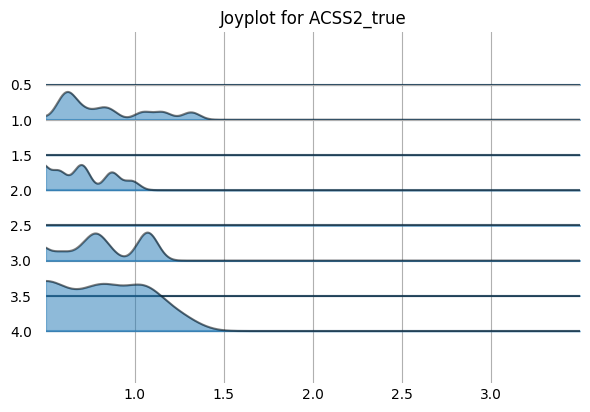

In [605]:
for gene in ["ACSS2_true"]:
    #gene_true = gene+"_true"
    # Create a joyplot for the current gene
    fig, axes = joypy.joyplot(
        df[[gene, "new_dosage"]],
        by='new_dosage',
        alpha=0.5,
        figsize=(6, 4),
        grid='both',
        bw_method=0.5,
        x_range=[0.5, 3.5],
    )
    
    # Set plot title
    plt.title(f'Joyplot for {gene}')
    
    # Show the plot
    plt.show()

# Ask chatGPT whether there is a 

In [452]:
adata_train.obs["condition"].value_counts()[:20]

condition
MCF7_Vehicle_0.0                               5858
K562_Vehicle_0.0                               2859
A549_Vehicle_0.0                               2787
MCF7_Mesna__100.0                               607
MCF7_Fasudil_(HA-1077)_HCl_10000.0              493
MCF7_Cerdulatinib_(PRT062070,_PRT2070)_10.0     476
MCF7_Tacedinaline_(CI994)_10.0                  475
MCF7_AZ_960_10.0                                472
MCF7_SRT2104_(GSK2245840)_1000.0                469
MCF7_Tofacitinib_(CP-690550)_Citrate_10.0       467
MCF7_PD98059_100.0                              467
MCF7_UNC0631_10.0                               466
MCF7_Filgotinib_(GLPG0634)_10.0                 465
MCF7_KW-2449_10.0                               463
MCF7_BRD4770_10.0                               458
MCF7_GSK-LSD1_2HCl_10.0                         457
MCF7_Resminostat_10.0                           457
MCF7_PJ34_10.0                                  454
MCF7_Divalproex_Sodium_1000.0                   446
MC

In [459]:
for c in adata_train.obs["condition"].value_counts().index[:50]:
    print(effect_d[c])

1.0
1.0
1.0
0.9148628633266936
0.8999773561916973
0.9613981601813449
0.9766742100867575
0.968701284535673
0.9355003969581882
0.9762187510021453
0.9686737325084019
0.9781749669510084
0.9715756168732133
0.9596814555898909
0.9749066164753295
0.9704264320343856
0.9503389564649072
0.9512930231373391
0.9491892824123236
0.970053285990682
0.8955774627093955
0.8691582236693566
0.9632079987706372
0.9674709326376765
0.9850158728810248
0.9635664340082148
0.9429613289717759
0.9690640751503755
0.9555966270250092
0.9470286707075195
0.964850079571456
0.9317882735077126
0.9679600580318505
0.938810620756156
0.97243308670453
0.9580220352733086
0.9280672021992157
0.9527532022273243
0.9482272516643266
0.959153275445496
0.9334913645820817
0.9194134700965388
0.9601516098679641
0.9680940546684407
0.9704222736335786
0.9424002084062197
0.9557845955229625
0.9655548718820615
0.9486668851779245
0.9624400082345264


In [513]:
import anndata as ad

data_list = []
key_list = []

for key, arr in interpolation_results.items():
    data_list.append(np.asarray(arr))
    key_list.extend([key] * arr.shape[0])

combined_df = np.concatenate(data_list, axis=0)
adata_pred = ad.AnnData(X=combined_df)

# Add the keys as a new column in the obs attribute
adata_pred.obs['dosage'] = key_list


In [514]:
sc.pp.neighbors(adata_pred)

In [515]:
sc.tl.umap(adata_pred)

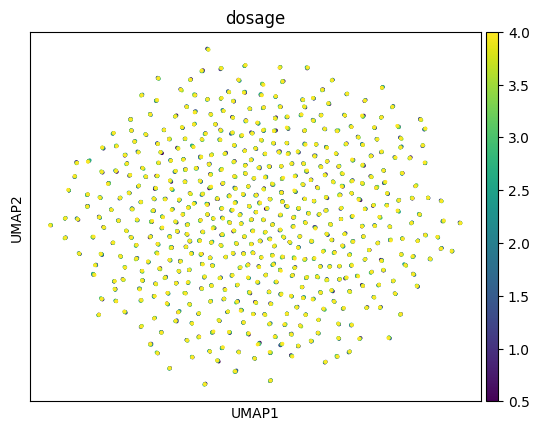

In [516]:
sc.pl.umap(adata_pred, color="dosage")

In [384]:
adata_red = adata_train[adata_train.obs["drug"]=="CUDC-907"]

In [385]:
adata_red

View of AnnData object with n_obs × n_vars = 1244 × 2002
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle', 'perturbation', 'drug', 'cell_line', 'logdose', 'condition', 'pubchem_name', 'pubchem_ID', 'smiles', 'control', 'ood', 'is_ood', 'split'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'pca', 'rank_genes_groups_cov_all'
    obsm: 'X_pca', 'cell_line_emb', 'ecfp', 'ecfp_cell_line', 'ecfp_cell_line_dose', 'ecfp_cell_line_dose_more_dose', 'ecfp_cell_line_logdose', 'ecfp_cell_line_logdose_more_dose'
    varm: 'PCs', 'X_train_mean'
    layers: 'X_log1p', 'centered_X'

In [386]:
sc.pp.neighbors(adata_red)

In [388]:
sc.tl.umap(adata_red)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


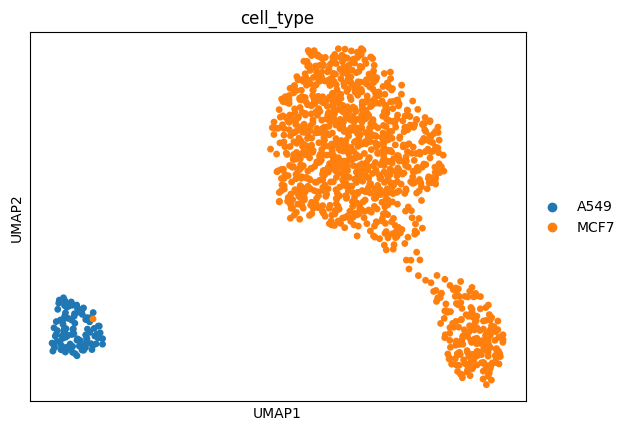

In [586]:
sc.pl.umap(adata_red, color="cell_type")

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


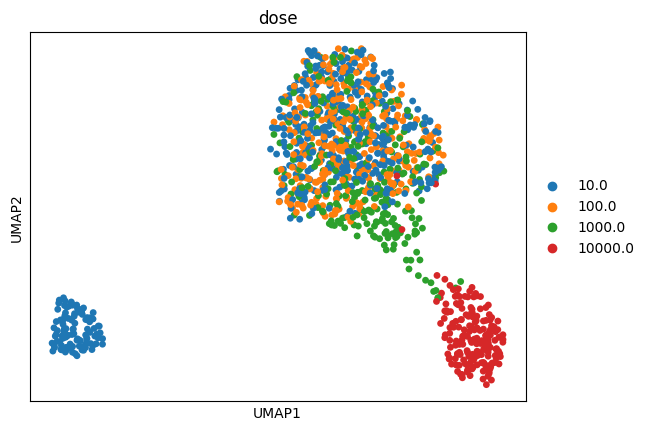

In [389]:
sc.pl.umap(adata_red, color="dose")

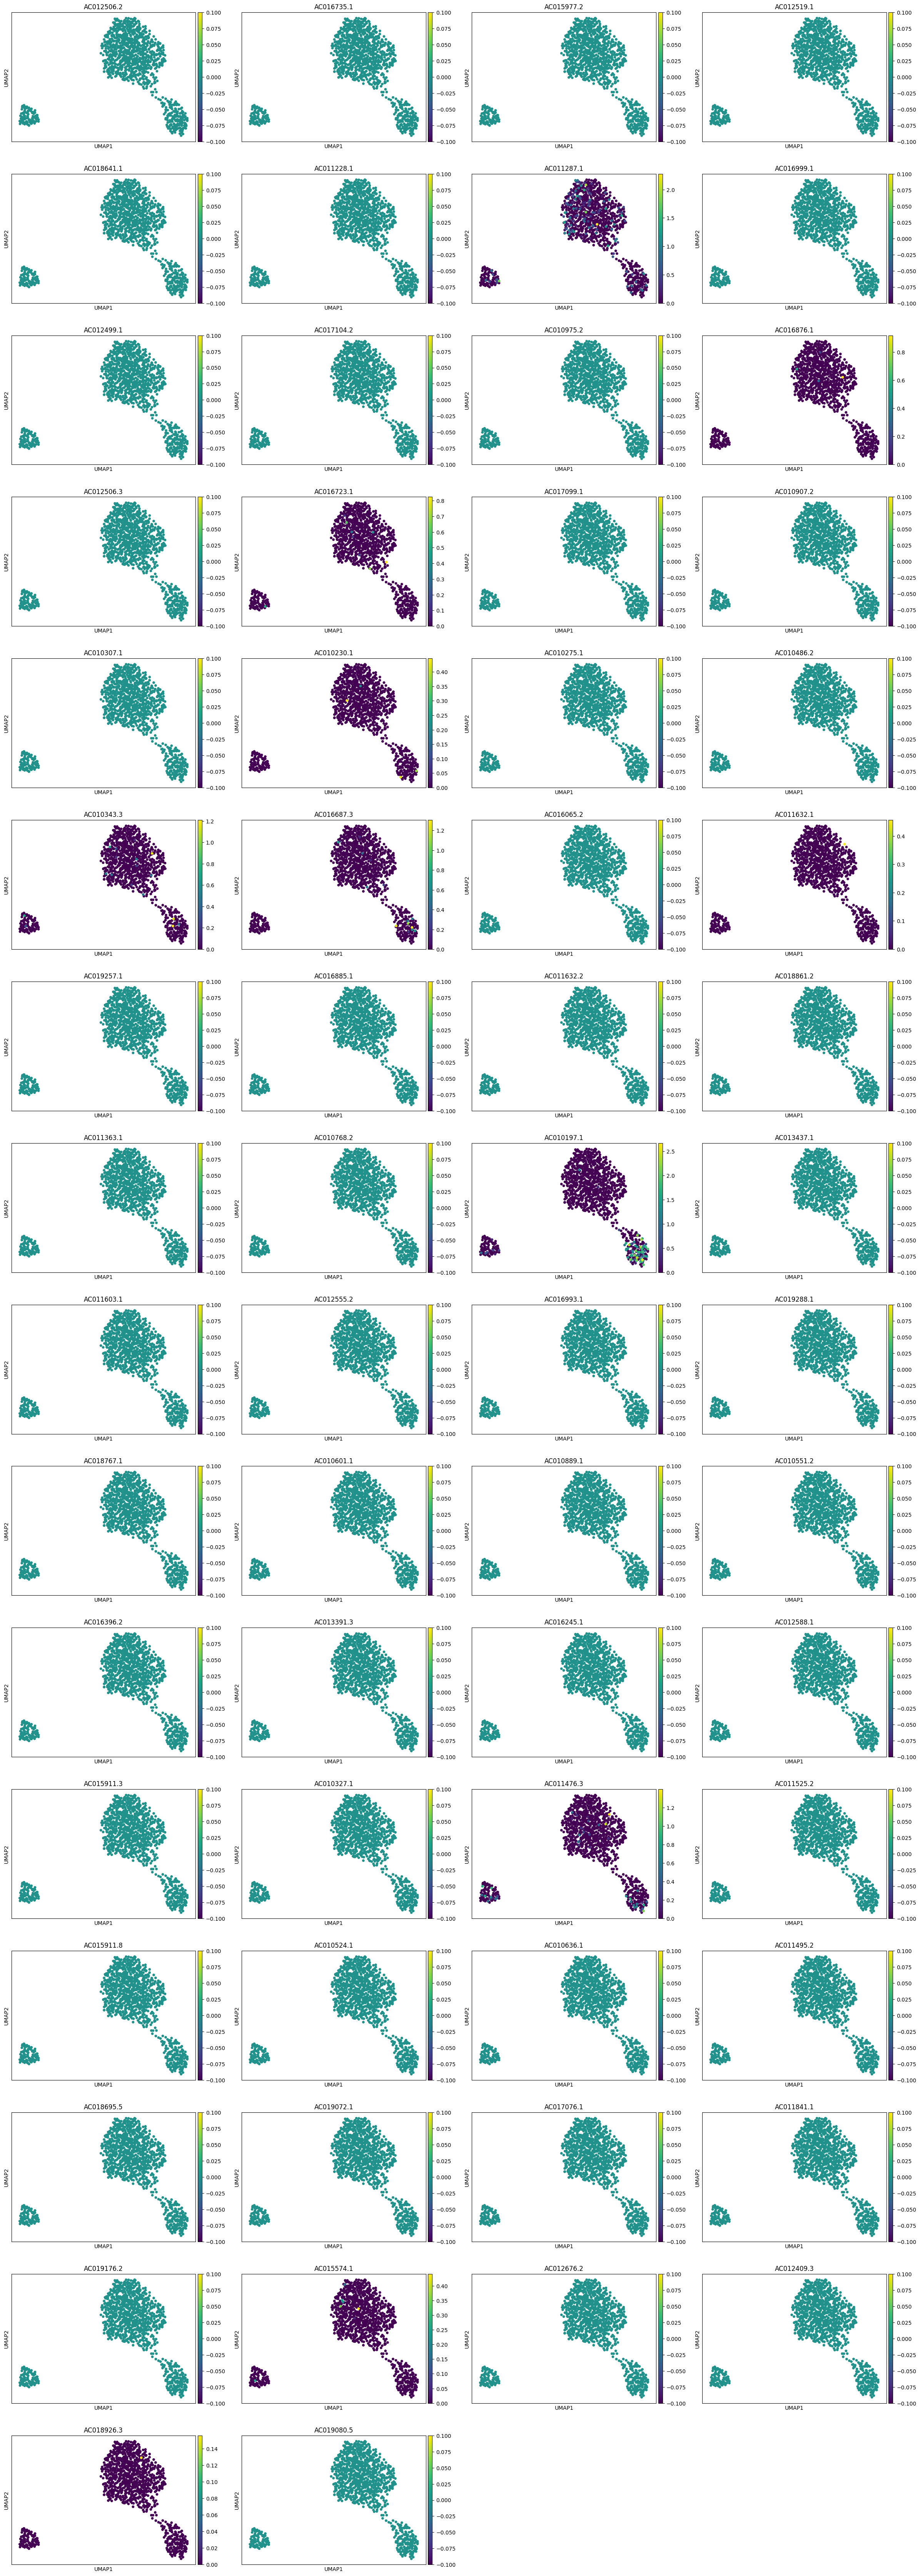

In [603]:
sc.pl.umap(adata_red, color=ac01_genes)

In [400]:
sc.pp.highly_variable_genes(adata_red, n_top_genes=20)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [445]:
gg = adata_red[:,adata_red.var["highly_variable"]].var_names

In [434]:
[el for el in adata.var_names.values if "SIRT" in el]

[]

In [435]:
gg = ['ACSS2'] + ac01_genes + ['SLC12A2', 'SLC25A21']

In [517]:
ac01_genes

['AC012506.2',
 'AC016735.1',
 'AC015977.2',
 'AC012519.1',
 'AC018641.1',
 'AC011228.1',
 'AC011287.1',
 'AC016999.1',
 'AC012499.1',
 'AC017104.2',
 'AC010975.2',
 'AC016876.1',
 'AC012506.3',
 'AC016723.1',
 'AC017099.1',
 'AC010907.2',
 'AC010307.1',
 'AC010230.1',
 'AC010275.1',
 'AC010486.2',
 'AC010343.3',
 'AC016687.3',
 'AC016065.2',
 'AC011632.1',
 'AC019257.1',
 'AC016885.1',
 'AC011632.2',
 'AC018861.2',
 'AC011363.1',
 'AC010768.2',
 'AC010197.1',
 'AC013437.1',
 'AC011603.1',
 'AC012555.2',
 'AC016993.1',
 'AC019288.1',
 'AC018767.1',
 'AC010601.1',
 'AC010889.1',
 'AC010551.2',
 'AC016396.2',
 'AC013391.3',
 'AC016245.1',
 'AC012588.1',
 'AC015911.3',
 'AC010327.1',
 'AC011476.3',
 'AC011525.2',
 'AC015911.8',
 'AC010524.1',
 'AC010636.1',
 'AC011495.2',
 'AC018695.5',
 'AC019072.1',
 'AC017076.1',
 'AC011841.1',
 'AC019176.2',
 'AC015574.1',
 'AC012676.2',
 'AC012409.3',
 'AC018926.3',
 'AC019080.5']